# <font color='darkgreen'>MODELAGEM DE SÉRIES TEMPORAIS - PARTE II</font>
## <font color='darkgreen'>SÉRIE TEMPORAL DA COTAÇÃO DO OURO</font>

Na segunda etapa do projeto, o foco será aprofundar a análise da série temporal, investigando a estacionariedade da série. Caso seja detectada não estacionariedade, serão aplicadas técnicas de transformação para tornar a série estacionária.

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('A verão python utilizada neste jupyter notebook:', python_version())

A verão python utilizada neste jupyter notebook: 3.11.5


## Instalar e Carregar Pacotes

In [2]:
# Imports pacotes

# Manipular dados
import numpy as np
import pandas as pd

# Visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Análise e modelagem de séries temporais
import scipy
from scipy.stats import boxcox
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

In [3]:
# Gravar versões de pacotes
# !pip install -q -U watermark

In [4]:
# Versões dos pacotes
%reload_ext watermark
%watermark --iversions

statsmodels: 0.14.0
scipy      : 1.11.1
numpy      : 1.24.3
pandas     : 2.0.3
platform   : 1.0.8
matplotlib : 3.7.2
seaborn    : 0.12.2



## Carregar Dados

In [5]:
# Criar uma lista para identificar valores ausentes
rotulos_valores_ausentes = ["na", "undefined"]

In [6]:
# Carregar dataset
df_origin = pd.read_csv("dataset.csv", na_values = rotulos_valores_ausentes)

In [7]:
# Cópia dataset original
df = df_origin.copy()

In [8]:
df.shape

(10787, 2)

In [9]:
# Checando os nomes das variáveis
df.head()

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4


In [10]:
# Convertendo a coluna 'Date' para datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [11]:
# Transformar a variável datesold como índice 
df_serie = df.set_index('Date')

In [12]:
df_serie.head()

,Value
Date,
1970-01-01,35.2
1970-04-01,35.1
1970-07-01,35.4
1970-10-01,36.2
1971-01-01,37.4


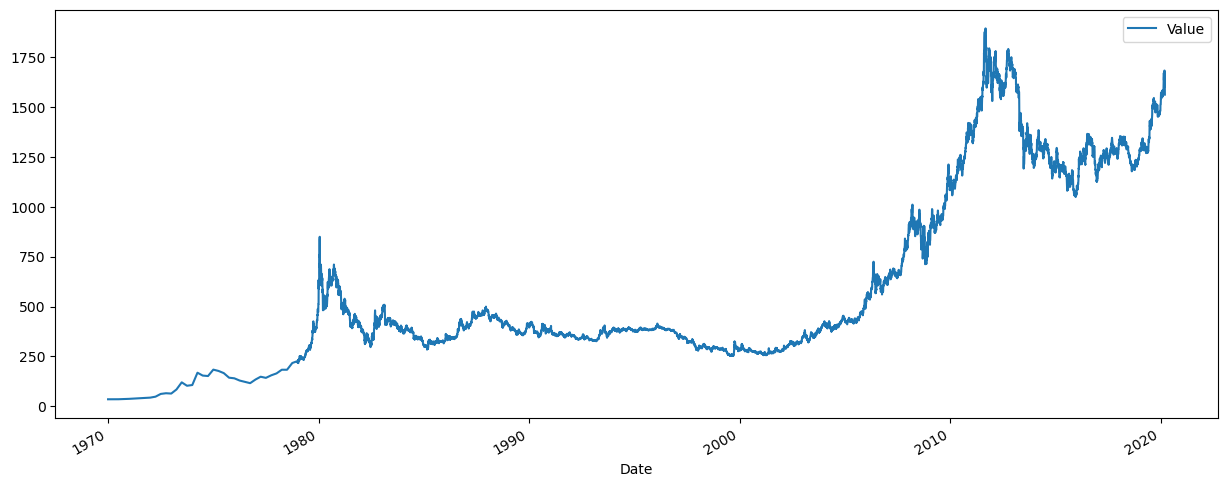

In [13]:
# Plot da Série Temporal
df_serie.plot(figsize = (15, 6))
plt.show()

O gráfico acima mostra 2 componentes da série: Sazonalidade e Tendência.

- Sazonalidade - o fenômeno se repete em períodos fixos.

- Tendência - ao longo do tempo, a série segue uma tendência de crescimento.

## Análise das Propriedades Estatística da Série Temporal

Precissamos verificar se as propriedades estatísticas são constantes na série temporal, realizando análise das estatísticas móveis como: média, mediana, soma, variância e desvio padrão, em uma janela deslizante de tamanho fixo ao longo da série.

Estacionariedade: a série temporal **deve ser estacionária**, ou seja, suas características estatísticas, como média e variância, não mudam ao longo do tempo.

Não-autocorrelação: as observações da série temporal não devem ser fortemente correlacionadas com observações anteriores.

Normalidade: é frequentemente pressuposto que as observações da série temporal são distribuídas normalmente (seguem uma distribuição normal).

In [14]:
type(df)

pandas.core.frame.DataFrame

In [15]:
# Determinando estatísticas móveis
rolmean = df['Value'].rolling(window = 30).mean()
rolstd = df['Value'].rolling(window = 30).std()

In [16]:
# Prepara os dados para o plot
x = df['Date'].values
y = df['Value'].values

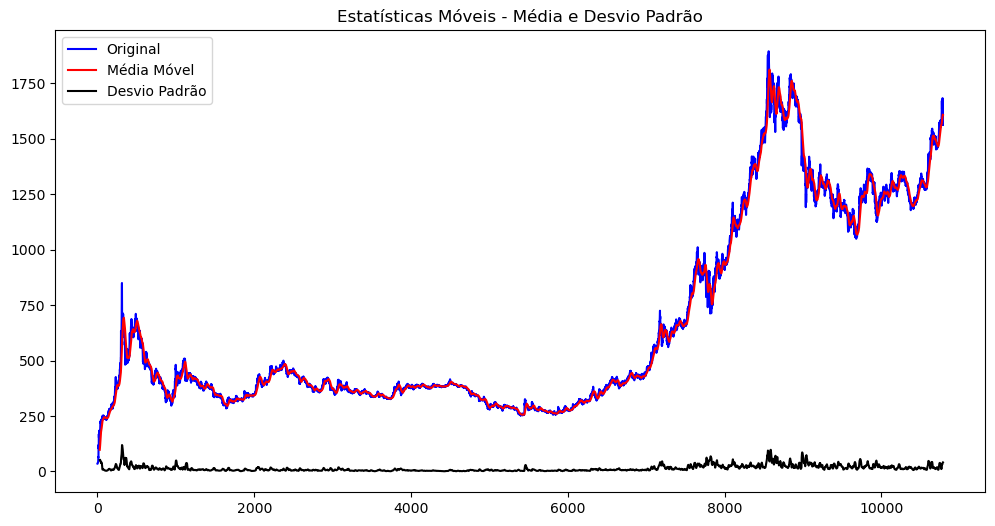

In [17]:
# Plot das estatísticas móveis
plt.figure(figsize = (12, 6))
orig = plt.plot(y, color = 'blue', label = 'Original')
mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
plt.legend(loc='best')
plt.title('Estatísticas Móveis - Média e Desvio Padrão')
plt.show()

**Análise & Insights:**
    
A série não é estacionária, pois tanto a média móvel quanto o desvio padrão variam ao longo do tempo, evidenciando a falta de constância nesses parâmetros. Dessa forma, ela não é adequada para ser utilizada diretamente em modelos de aprendizado sem transformação.

**Decisão:**
Realizar as transformações necessárias para uso em modelos de machine learning.

### Plots da Função de Autocorrelação (ACF) e Função de Autocorrelação Parcial (PACF)

Vamos criar os gráficos da ACF e PACF.

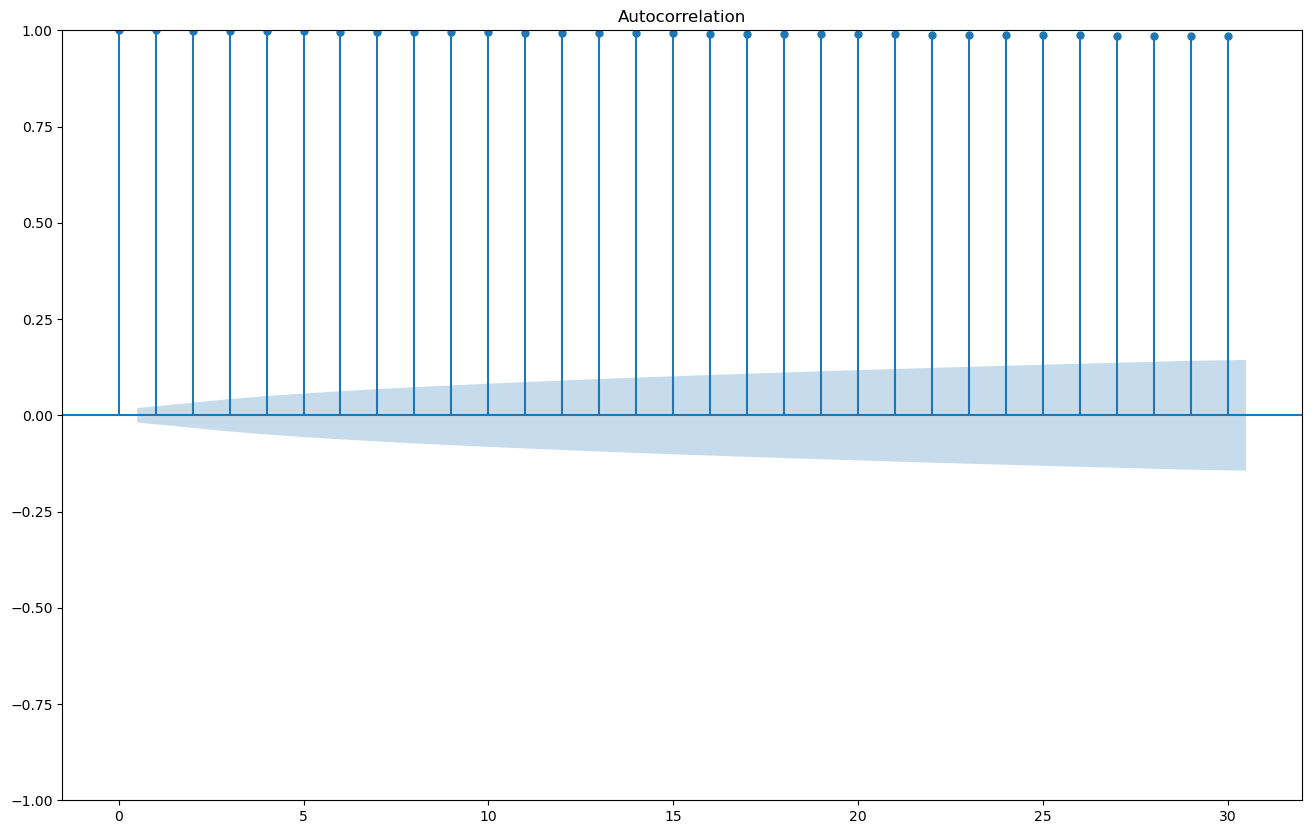

In [18]:
# Plots
plt.rcParams.update({'figure.figsize': (16,10)})

# Plot do gráfico ACF sem subplot
plot_acf(df.Value, lags=30)
plt.show()

Interpretação dos Gráficos:

No gráfico, o eixo vertical indica a autocorrelação e o horizontal a defasagem. 

Área sombreada: representa os intervalos de confiança (95%) para os coeficientes de autocorrelação.
Esses intervalos de confiança são usados para determinar se um valor de autocorrelação em determinado atraso (lag) é estatisticamente significativo, se os valores de autocorrelação caírem fora dessa região sombreada, eles são considerados significativamente diferentes de zero, sugerindo que há correlação para aquele lag.

Se a autocorrelação estiver dentro da área sombreada, isso indica que o valor pode ser explicado por variação aleatória, ou seja, a autocorrelação não é significativamente diferente de zero para aquele lag.

Em termos simples: a área sombreada aponta a significância. Se ultrapassada é porque tem correlação.

Cada barra no gráfico ACF representa o nível de correlação entre a série e seus atrasos em ordem cronológica. A área sombreada indica se o nível de correlação entre a série e cada atraso é significativo ou não. 

**Análise & Insights**

Os valores da ACF (barras verticais) estão acima do limite da área sombreada, o que significa que a autocorrelação é significativamente diferente de zero, sugerindo que a série não é aleatória.

Quando a barra vertical se mantém em 1.0 e permanece acima da área sombreada para vários lags, isso indica um forte padrão de autocorrelação positiva.

Tendência persistente: Os valores passados têm uma forte influência nos valores futuros, indicando que a série mantém uma tendência ao longo do tempo.

Série não estacionária: A autocorrelação alta no lag 1 e em lags subsequentes sugere que a série temporal pode ser não estacionária, ou seja, suas estatísticas (como média e variância) mudam ao longo do tempo. Nesses casos, pode ser necessária uma transformação, como a diferenciação, para torná-la estacionária e facilitar a modelagem.

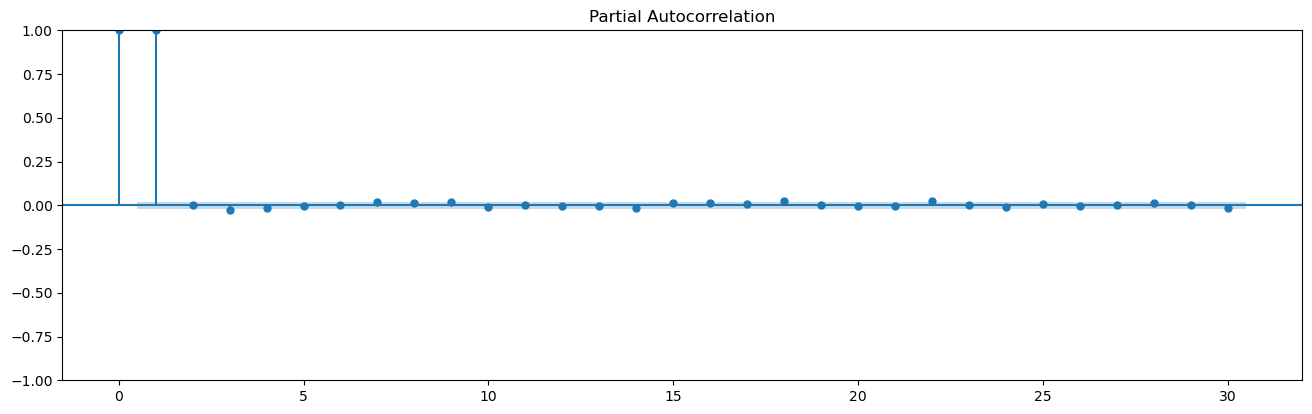

In [19]:
# Plot do gráfico PACF
plt.subplot(212)
plot_pacf(df.Value, ax = plt.gca(), lags = 30, method = 'ywm')
plt.show()

A função de autocorrelação parcial (PACF) mede a correlação entre uma série temporal e seus lags, eliminando o efeito de intermediários. 

Forte autocorrelação nos dois primeiros lags: Isso sugere que as observações da série temporal estão altamente correlacionadas com os valores dos dois lags anteriores, podendo indicar que a série tem uma forte dependência de curto prazo.

Descorrelação nos lags seguintes: A ausência de correlação significativa nos lags após o segundo implica que, além desses dois primeiros lags, os lags mais distantes não têm uma influência direta sobre o valor atual da série. O efeito de lags superiores já foi "explicado" pelos dois primeiros lags.

Essa configuração é comum em séries temporais que podem ser modeladas com um processo AR(2) (modelo autoregressivo de ordem 2), onde o comportamento da série é bem capturado pelos dois lags anteriores, sem a necessidade de incluir lags adicionais.

Podemos planejar o uso de um modelo ARIMA,  com o componente AR do modelo (autoregressivo) tendo uma ordem de 2 (AR(2)).

### Teste Estatístico Dickey-Fuller Aumentado

O Teste Estatístico Dickey-Fuller Aumentado (ADF - Augmented Dickey-Fuller) é uma extensão do teste de Dickey-Fuller padrão, amplamente utilizado para verificar a estacionaridade de uma série temporal. Ele é essencial em análises de séries temporais, pois muitos modelos, como o ARIMA, pressupõem que os dados sejam estacionários (ou seja, que suas propriedades estatísticas, como média e variância, sejam constantes ao longo do tempo).

Hipóteses do Teste ADF:
Hipótese Nula(H0): A série temporal tem uma raiz unitária, ou seja, não é estacionária.
Hipótese Alternativa (H1): A série temporal não tem raiz unitária, ou seja, é estacionária.

Ou, de forma mais simples:

- Hipótese Nula (H0): A série temporal não é estacionária.
- Hipótese Alternativa (H1) - A série temporal é estacionária.

In [20]:
# Teste Dickey-Fuller

# Print
print('\nResultado do Teste Dickey-Fuller:\n')

# Teste
dfteste = adfuller(df_serie.Value, autolag = 'AIC')

# Formatando a saída
dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                           'Valor-p',
                                           'Número de Lags Consideradas',
                                           'Número de Observações Usadas'])

# Loop por cada item da saída do teste
for key,value in dfteste[4].items():
    dfsaida['Valor Crítico (%s)'%key] = value

# Print
print (dfsaida)


Resultado do Teste Dickey-Fuller:

Estatística do Teste               -0.071121
Valor-p                             0.952240
Número de Lags Consideradas        39.000000
Número de Observações Usadas    10747.000000
Valor Crítico (1%)                 -3.430959
Valor Crítico (5%)                 -2.861809
Valor Crítico (10%)                -2.566913
dtype: float64


**Análise e Insights:**

O Valor-p maior que 0.05 e a Estatística do Teste (-0.0711) maior que todos os valores críticos (níveis de confiança), indicam que não temos evidências estatísticas para rejeitar a hipótese nula. Logo, podemos concluir que a série provavelmente **NÃO é estacionária.**

## TRANSFORMAÇÕES EM SÉRIES TEMPORAIS

## Transformação de Log

In [21]:
# Realiza a transformação logarítmica na coluna 'Value'
df_serie['Log_Value'] = np.log(df_serie['Value'])
df_serie

,Value,Log_Value
Date,,
1970-01-01,35.20,3.561046
1970-04-01,35.10,3.558201
1970-07-01,35.40,3.566712
1970-10-01,36.20,3.589059
1971-01-01,37.40,3.621671
...,...,...
2020-03-09,1672.50,7.422075
2020-03-10,1655.70,7.411979
2020-03-11,1653.75,7.410801


In [22]:
# Função testar a estacionaridade (Teste Dickey-Fuller)
def testa_estacionaridade(serie, window = 30, title='Estatísticas Móveis e Teste Dickey-Fuller'):
   
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = window).mean()
    rolstd = serie.rolling(window = window).std()

    # Plot das estatísticas móveis
    plt.figure(figsize = (14, 6))
    plt.plot(serie, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    plt.plot(rolstd, color = 'black', label = 'Desvio Padrão Móvel')
    plt.legend(loc='best')
    plt.title(title)
    plt.show(block=False)
    
    # Teste Dickey-Fuller
    print('\nResultado do Teste Dickey-Fuller:')
    dfteste = adfuller(serie, autolag='AIC')
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste', 
                                               'Valor-p', 
                                               'Número de Lags Consideradas', 
                                               'Número de Observações Usadas'])
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)' % key] = value
        
    print(dfsaida)
    
        # Conclusão baseada no valor-p
    if dfsaida['Valor-p'] > 0.05:
        print('\nCONCLUSÃO:\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente não é estacionária.')
    else:
        print('\nCONCLUSÃO:\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente é estacionária.')   


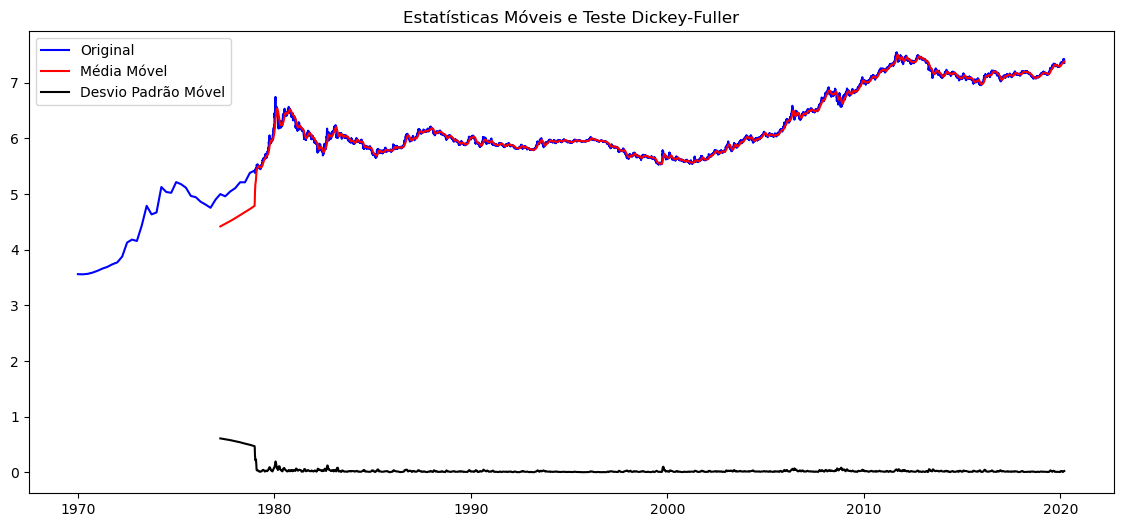


Resultado do Teste Dickey-Fuller:
Estatística do Teste               -1.011225
Valor-p                             0.749148
Número de Lags Consideradas        21.000000
Número de Observações Usadas    10765.000000
Valor Crítico (1%)                 -3.430958
Valor Crítico (5%)                 -2.861809
Valor Crítico (10%)                -2.566913
dtype: float64

CONCLUSÃO:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [23]:
testa_estacionaridade(df_serie['Log_Value'])

## Transformação de Raiz Quadrada

In [24]:
# Transformação de Raiz Quadrada com np.sqrt()
df_serie_sqrt = np.sqrt(df_serie['Value'])

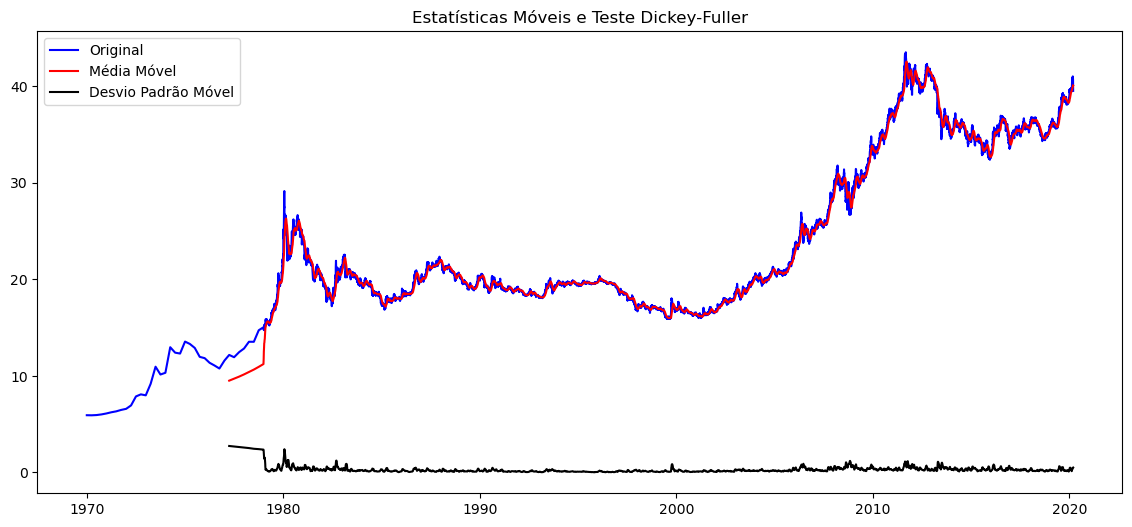


Resultado do Teste Dickey-Fuller:
Estatística do Teste               -0.529550
Valor-p                             0.886120
Número de Lags Consideradas        21.000000
Número de Observações Usadas    10765.000000
Valor Crítico (1%)                 -3.430958
Valor Crítico (5%)                 -2.861809
Valor Crítico (10%)                -2.566913
dtype: float64

CONCLUSÃO:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [25]:
testa_estacionaridade(df_serie_sqrt)

## Transformação Box-Cox

In [26]:
# Aplicando Transformação Box-Cox
df_serie['Value_box'] = boxcox(df_serie['Value'], lmbda = 0.0)

In [27]:
df_serie.head()

,Value,Log_Value,Value_box
Date,,,
1970-01-01,35.2,3.561046,3.561046
1970-04-01,35.1,3.558201,3.558201
1970-07-01,35.4,3.566712,3.566712
1970-10-01,36.2,3.589059,3.589059
1971-01-01,37.4,3.621671,3.621671


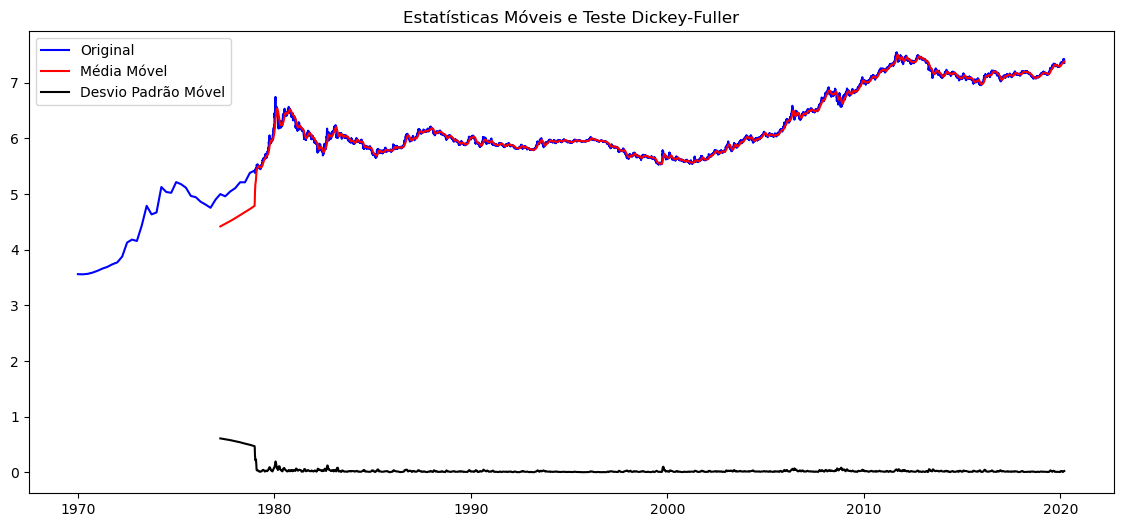


Resultado do Teste Dickey-Fuller:
Estatística do Teste               -1.011225
Valor-p                             0.749148
Número de Lags Consideradas        21.000000
Número de Observações Usadas    10765.000000
Valor Crítico (1%)                 -3.430958
Valor Crítico (5%)                 -2.861809
Valor Crítico (10%)                -2.566913
dtype: float64

CONCLUSÃO:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [28]:
testa_estacionaridade(df_serie['Value_box'])

### Vamos definir o parâmetro lambda como None (o padrão) para permitir que a função determine automaticamente um valor estatisticamente ajustado.

In [29]:
# Aplicar valor ideal de Lambda (transformação Box-Cox) 
df_serie['Value_box_2'], lam_value = boxcox(df_serie['Value'])
print('Valor Ideal de Lambda: %f' % lam_value)
df_serie.head()

Valor Ideal de Lambda: -0.379303


,Value,Log_Value,Value_box,Value_box_2
Date,,,,
1970-01-01,35.2,3.561046,3.561046,1.953438
1970-04-01,35.1,3.558201,3.558201,1.952701
1970-07-01,35.4,3.566712,3.566712,1.954904
1970-10-01,36.2,3.589059,3.589059,1.960657
1971-01-01,37.4,3.621671,3.621671,1.968964


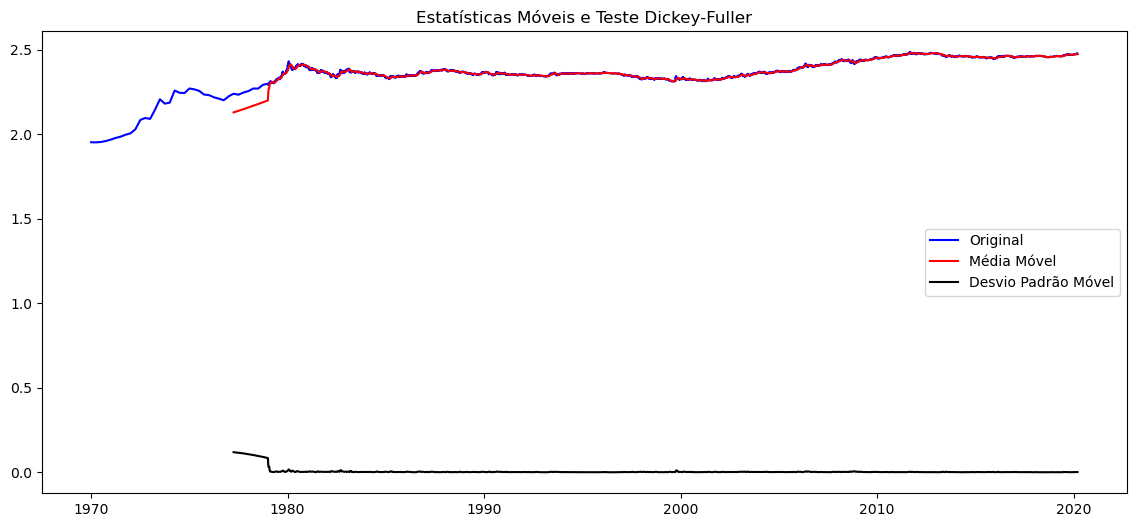


Resultado do Teste Dickey-Fuller:
Estatística do Teste               -1.454307
Valor-p                             0.555982
Número de Lags Consideradas        21.000000
Número de Observações Usadas    10765.000000
Valor Crítico (1%)                 -3.430958
Valor Crítico (5%)                 -2.861809
Valor Crítico (10%)                -2.566913
dtype: float64

CONCLUSÃO:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [30]:
testa_estacionaridade(df_serie['Value_box_2'])

**CONCLUSÃO/RESUMO:**

Nenhuma das técnicas utilizadas apresentou resultado para tornar a série estacionária. 
Vamos continuar o projeto no próximo jupyter notebook. 

### FIM DA PARTE II DO PROJETO